In [40]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
# Import modules
from elastica.modules import BaseSystemCollection, Constraints, Forcing, Damping

# Import Cosserat Rod Class
from elastica.rod.cosserat_rod import CosseratRod

# Import Damping Class
from elastica.dissipation import AnalyticalLinearDamper

# Import Boundary Condition Classes
from elastica.boundary_conditions import OneEndFixedRod, FreeRod
from elastica.external_forces import EndpointForces 
from elastica.external_forces import GravityForces

# Import Timestepping Functions
from elastica.timestepper.symplectic_steppers import PositionVerlet 
from elastica.timestepper import extend_stepper_interface
from elastica.timestepper import integrate 

In [65]:
%matplotlib inline
time = 0
class PendulumSimulator(BaseSystemCollection, Constraints, Forcing, Damping):
    pass 

Pendulum_Sim = PendulumSimulator()

# Create Rod 
n_elem = 100 

density = 1000
nu = 1e-4 #damping constant
E = 1e6
poisson_ratio = 1
shear_modulus = E / (poisson_ratio + 1.0)

start = np.array([0.0,0.0,5.0])
direction = np.array([0.0, 1.0, -1.0])
normal = np.array([1.0, 0.0, 0.0])
base_length = 3.0
base_radius = 0.25
base_area = np.pi * base_radius**2

origin_force = np.array([0.0, 0.0, 0.0])
end_force = np.array([0.0, 0.0, -100.0])
ramp_up_time = 0.1

shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus=E,
    shear_modulus = shear_modulus,
)

unshearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    youngs_modulus = E,
    shear_modulus = E/(-0.7 + 1.0),
)

dl = base_length / n_elem 
dt = 0.01 * dl 
Pendulum_Sim.append(shearable_rod)
Pendulum_Sim.append(unshearable_rod)
Pendulum_Sim.dampen(shearable_rod).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)
Pendulum_Sim.dampen(unshearable_rod).using(
    AnalyticalLinearDamper,
    damping_constant = nu,
    time_step = dt,
)

Pendulum_Sim.constrain(shearable_rod).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (10,)
)
Pendulum_Sim.constrain(unshearable_rod).using(
    OneEndFixedRod,constrained_position_idx = (0,), constrained_director_idx= (0,)
)
print("One end of the rod is now fixed in place")

Pendulum_Sim.add_forcing_to(shearable_rod).using(
    GravityForces, acc_gravity = np.array([0.0,0.0,-9.8]) 
)
Pendulum_Sim.add_forcing_to(unshearable_rod).using(
    GravityForces, acc_gravity = np.array([0.0,0.0,-9.8]) 
)

Pendulum_Sim.add_forcing_to(shearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time = ramp_up_time
)
Pendulum_Sim.add_forcing_to(unshearable_rod).using(
    EndpointForces, origin_force, end_force, ramp_up_time=ramp_up_time
)
print("Forces added to the rod")

Pendulum_Sim.finalize()
print("System finalized")
#integrate(timestepper, Pendulum_Sim, final_time, total_steps)
def run_and_update_plot(simulator, dt, start_time, stop_time, ax):
    timestepper = PositionVerlet()
    do_step, stages_and_updates = extend_stepper_interface(timestepper, simulator)

    n_steps = int((stop_time - start_time)/ dt)
    time = start_time
    for i in range(n_steps):
        time = do_step(timestepper, stages_and_updates, simulator, time, dt)
    plot_pendulum_dynamic(shearable_rod, unshearable_rod, time, ax)
    return time 

def plot_pendulum_dynamic(rod1,rod2, time, ax):
    ax.clear()
    ax.grid(which="major", color="grey", linestyle="-", linewidth=0.25)
    ax.plot(
        rod1.position_collection[1,:],
        rod1.position_collection[2,:],
        "b-",
        label = "shearable rod",
    )
    ax.plot(
        rod2.position_collection[1,:],
        rod2.position_collection[2,:],
        'r-',
        label = "unshearable_rod"
    )
    ax.legend(prop={"size":12}, loc="lower left")
    ax.set_ylabel("Y Position (m)", fontsize=12)
    ax.set_xlabel("X Position (m)", fontsize=12)
    ax.set_title(f"Simulation Time: {time:.2f} seconds")
    ax.set_ylim([-5,5.1])
    ax.set_xlim([-5,5])


One end of the rod is now fixed in place
Forces added to the rod
System finalized


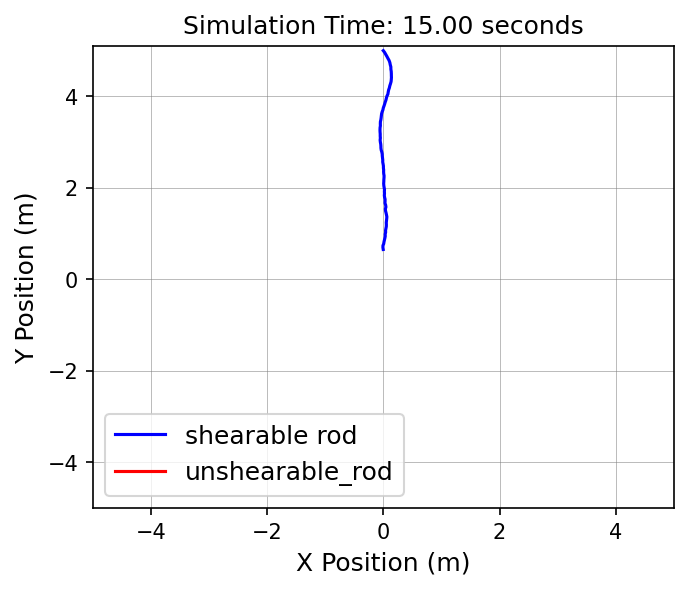

In [66]:
%matplotlib inline
evolve_for_time = 15.0
update_interval = 1.0e-1 

import cv2,os
# update the plot every 0.1 second
fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
ax = fig.add_subplot(111)

plt.savefig('Pendulum.jpg')
video_name = 'Pendulum.mp4'
frame = cv2.imread('Pendulum.jpg')
height, width, layers = frame.shape
fourcc = cv2.VideoWriter_fourcc('M','P','4','V') # 解码器
video = cv2.VideoWriter(video_name,fourcc,1,(width,height))
first_interval_time = update_interval + time 
last_interval_time = time + evolve_for_time
for stop_time in np.arange(
    first_interval_time, last_interval_time+dt, update_interval
):
    time = run_and_update_plot(Pendulum_Sim, dt, time, stop_time, ax)
    display.clear_output(wait=True)
    image = plt.gcf()
    display.display(image)
    plt.savefig('Pendulum.jpg')
    video.write(cv2.imread("Pendulum.jpg"))
plt.close()
cv2.destroyAllWindows()
video.release()